# はじめに

このノートでは、lightGBMのアルゴリズムに関して、基本的な部分をおさらいして、まとめている。下記の書籍のコードと論文を参考にしている。

- [LightGBM予測モデル実装ハンドブック](https://www.shuwasystem.co.jp/book/9784798067612.html)
- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

今回はlightGBMで2値分類に対して、アーリーストッピングを使って、どのようにバリデーションを行うかに焦点をあてている。

## モデルの学習

必要なライブラリをインポートしておく。

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# 層化分割のクロスバリデーション
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

ここで使用するデータは、1994年のアメリカの国勢調査に関するサンプルデータ。データの説明は下記の通り。`income`が目的変数で5万ドルを基準に2つに分割されている。

|変数|説明|
|:---|:---|
|`age`| 年齢|
|`workclass`| 雇用形態|
|`fnlwgt`| ？|
|`education`| 学歴|
|`education-num`| 教育年数|
|`marital-status`| 配偶者のありなし|
|`occupation`| 職業|
|`relationship`| 世帯内の関係|
|`race`| 人物|
|`gender`| 性別|
|`capital-gain`| キャピタルゲイン|
|`capital-loss`| キャピタルロス|
|`hours-per-week`| 1週間の労働時間|
|`native-country`| 母国|
|`income`| 収入(<=50Kは5万ドル以下、>50kは5万ドル超え)|


In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


モデルを学習させるための前処理を行っておく。

In [3]:
# 前処理
# 文字列の半角スペース削除
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
for s in cat_cols:
  df[s] =df[s].str.replace(' ', '')

# United-Statesのレコードに絞り特徴量native-countryを削除
df = df[df['native-country'].isin(['United-States'])]
df = df.drop(['native-country'], axis=1)
df.reset_index(inplace=True, drop=True)

# 正解ラベルの数値への置換
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)


## ホールドアウト法

アーリーストッピングの機能を使う以前にモデル評価における、データの分割をおさらいしておく。ハイパーパラメタのチューニングが不要なモデル以外では、学習とテストの2種類にデータを分けて評価を行うことは少ないと思われる。学習と検証、テストの3種類に分けて評価するのが一般的。このようにデータを分割することで、検証データでパラメタのチューニングを行い、テストデータはモデルの汎化性能を高めるために利用する。

加え、データを分割する方法も考えないといけないが、まず、ホールドアウト法を利用して、学習、検証、テストを6:2:2くらいの割合でデータを分割し、アーリーストッピングの機能を使ってみる。

In [4]:
# 特徴量と目的変数の設定
X = df.drop(['income'], axis=1)
y = df['income']
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
# print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

# カテゴリ変数の前処理
# カテゴリ変数のlabel encoding
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

    # データ型をcategory型に変換
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

#X_train.info()
# 学習データの20%を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape)
print('X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)
print('X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trの形状： (18668, 13)  y_trの形状： (18668,)
X_vaの形状： (4668, 13)  y_vaの形状： (4668,)
X_testの形状： (5834, 13)  y_testの形状： (5834,)


学習データ、検証データを利用してモデルを学習する。そもそもアーリーストッピングとは何か。アーリーストッピングはブースティング回数をコントロールする機能で、LightGBMはブースティング回数を増やせば増やすほどテストデータに対して過学習をしてしまいやすい性質がある。そこでアーリーストッピングでは、検証データをパラメタのチューニングに使用し、検証データの誤差が低下しなくなったら、ブースティング回数をその時点で終了させる。こうすることでモデルの過学習を防ぐことができる。下記では、`early_stopping(10)`としているため、10回実行しても誤差が低下しないとき、学習を終了する。

In [5]:
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'binary',
    'num_leaves': 5,
    'seed': 0,
    'verbose': -1,
}

# 誤差プロットの格納用データ
evals_result = {} 
# モデルの学習
model = lgb.train(
  params,
  lgb_train,
  num_boost_round=500,
  valid_sets=[lgb_train, lgb_eval],
  valid_names=['train', 'valid'],
  callbacks=[
    lgb.early_stopping(10),
    lgb.log_evaluation(100),
    lgb.record_evaluation(evals_result)
    ]
  )

Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.285093	valid's binary_logloss: 0.297689
[200]	train's binary_logloss: 0.271357	valid's binary_logloss: 0.291118
Early stopping, best iteration is:
[200]	train's binary_logloss: 0.271357	valid's binary_logloss: 0.291118


学習データと検証データの誤差プロットを確認すると、200回目あたりでオレンジ色の線が下降しなくなっている。つまり、学習しても誤差が改善されないので、この時点で学習が終了されている。

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

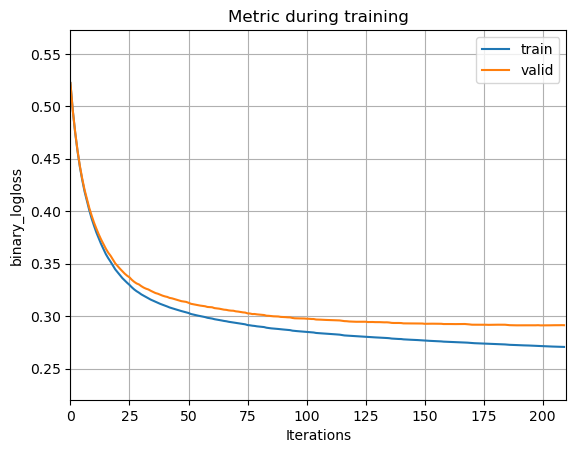

In [6]:
# 学習が停止したブースティング回数
# model.best_iteration: 200
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

検証データの予測と評価、テストデータの予測と評価を行うことで、検証データが過学習しているかを確認する。まずは検証データの評価指標は`Accuracy=0.87`、`F1-score=0.70`である。一方で、テストデータの評価指標は`Accuracy=0.86`、`F1-score=0.68`であるため、少しではあるが、検証データに過学習してしまっていることがわかる。

In [7]:
# 検証データの予測と評価
y_va_pred_proba = model.predict(X_va, num_iteration=model.best_iteration) # ラベル1の確率
print('ラベル1の確率：', y_va_pred_proba)
y_va_pred = np.round(y_va_pred_proba) # 確率をラベル0 or 1に変換
print('予測ラベル値：', y_va_pred)

ac_score = accuracy_score(y_va, y_va_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_va, y_va_pred)
print('F1-score = %.2f' % (f1))

ラベル1の確率： [0.03758662 0.00051379 0.16303104 ... 0.00878358 0.07152312 0.41445192]
予測ラベル値： [0. 0. 0. ... 0. 0. 0.]
accuracy = 0.87
F1-score = 0.70


In [8]:
# テストデータの予測と評価
y_test_pred_proba = model.predict(X_test, num_iteration=model.best_iteration) # ラベル1の確率
print('ラベル1の確率：', y_test_pred_proba)
y_test_pred = np.round(y_test_pred_proba) # 確率をラベル0 or 1に変換
print('予測ラベル値：', y_test_pred)

ac_score = accuracy_score(y_test, y_test_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_test, y_test_pred)
print('F1-score = %.2f' % (f1))

ラベル1の確率： [0.02738649 0.1740557  0.19527131 ... 0.99293736 0.04875194 0.04739031]
予測ラベル値： [0. 0. 0. ... 1. 0. 0.]
accuracy = 0.86
F1-score = 0.68


## クロスバリデーション法

ホールドアウト法は、データを学習、検証、テストデータに3分割する。このとき、場合によっては、サンプルデータに偏りが生じてしまい、偏ったデータに対して学習することで汎化性能が失われる可能性がある。これを回避する方法として、クロスバリデーション法がある。

クロスバリデーション法では、学習データを分割する回数をK回に増やす。分割単位をHoldと呼ぶが、K-Hold作って、モデルを複数個作って、学習、検証していき、最終的には平均化することで偏りを防止する。例えば5Holdの場合、下記のようなイメージとなる。また、各Holdの学習に使用していない検証データのHoldを`Out Of Hold(oof)`と呼ぶ。`oof`は学習データの長さと同じになる。

In [9]:
# - Hold1: train / train / train / train / VALID
# - Hold2: train / train / train / VALID / train
# - Hold3: train / train / VALID / train / train
# - Hold4: train / VALID / train / train / train
# - Hold5: VALID / train / train / train / train
# ↓
# - Eval: VALID / VALID / VALID / VALID / VALID
# ↓
# 平均化

クロスバリデーションはホールドアウト法に比べると、時間もかかり、コードも少し複雑になる。

In [10]:
params = {
    'objective': 'binary',
    'num_leaves': 5,
    'seed': 0,
    'verbose': -1,
}

# 格納用データの作成
accuracy_scores = []
logloss_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr = X_train.iloc[tr_idx] # 学習データX
    X_va = X_train.iloc[va_idx] # 検証データX
    y_tr = y_train.iloc[tr_idx] # 学習データY
    y_va = y_train.iloc[va_idx] # 検証データY

    lgb_train = lgb.Dataset(X_tr, y_tr)                     # 学習データ
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train) # 検証データ

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train', 'valid'],
        callbacks=[lgb.early_stopping(10), # 各ホールドに対してアーリーストッピングを適用
        lgb.log_evaluation(100)]
        )

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration) # 検証データXで検証データ予測Yhatを予測
    accuracy = accuracy_score(y_va, np.round(y_va_pred))                # 検証データの予測値の評価
    logloss = log_loss(y_va, y_va_pred)
    print('------------------------------------------------------------------------')
    print(f'fold {fold+1} accuracy_score: {accuracy:4f}   logloss: {logloss:4f}')
    print('------------------------------------------------------------------------')
    
    # スコア、モデル、予測値の格納
    accuracy_scores.append(accuracy)
    logloss_scores.append(logloss)
    models.append(model)
    oof[va_idx] = y_va_pred # 使用された検証データを対応するインデックスの位置に保存



Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.288706	valid's binary_logloss: 0.287306
[200]	train's binary_logloss: 0.275793	valid's binary_logloss: 0.278749
Early stopping, best iteration is:
[278]	train's binary_logloss: 0.268845	valid's binary_logloss: 0.275477
------------------------------------------------------------------------
fold 1 accuracy_score: 0.873179   logloss: 0.275477
------------------------------------------------------------------------
Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.287829	valid's binary_logloss: 0.29263
[200]	train's binary_logloss: 0.274043	valid's binary_logloss: 0.284794
Early stopping, best iteration is:
[212]	train's binary_logloss: 0.272111	valid's binary_logloss: 0.283514
------------------------------------------------------------------------
fold 2 accuracy_score: 0.875509   logloss: 0.283514
------------------------------------------------------

あとは検証データの予測値で評価されているスコアを平均する。

In [11]:
# foldごとの検証データの正解率
print(accuracy_scores) 
print(logloss_scores)

# クロスバリデーションの平均スコア
cv_accuracy_score = np.mean(accuracy_scores)
cv_logloss_score = np.mean(logloss_scores)

print(f'CV accuracy score: {cv_accuracy_score:4f} ')
print(f'CV logloss score: {cv_logloss_score:4f} ')

[0.8731790916880892, 0.8755088922219841, 0.8688665095350332, 0.8744375401757017, 0.8643668309406471]
[0.2754773200078629, 0.28351396797714135, 0.28462885695176876, 0.28852073572865367, 0.28787500874310196]
CV accuracy score: 0.871272 
CV logloss score: 0.284003 


## クロスバリデーション後の予測モデル

クロスバリデーション法でモデルを学習したときの疑問として、テストデータはどのモデルで予測すればよいのだろうか。これに関してはいくつかの方法がある。ここでは`K=5`で話を進める。

- 1つ目: 1個の予測モデルを選択して予測値を計算する
- 2つ目: 5個の予測モデルそれぞれを用いて、テストデータで予測し、平均化することで予測値を計算する
- 3つ目: ベストなパラメタを使って、学習、検証データをまとめて学習データとして、再学習した1個の予測モデルで予測値を計算する

ここでは2つ目の方法を実装する。

In [12]:
# モデルごとのテストデータの予測
preds = []
for model in models:
  # クロスバリデーションで作成したモデルで予測
  y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
  # 5つの1次元配列[array([ ... ]),array([ ... ]),...,array([ ... ])]
  preds.append(y_test_pred) 

# 5つの1次元配列が行として積み重ねられた2次元の配列[[ ... ], [ ... ], ..., [ ... ]]
y_test_preds = np.array(preds) 
print('モデルごとの予測：', y_test_preds.shape)
print(y_test_preds)

モデルごとの予測： (5, 5834)
[[0.02017636 0.20380873 0.24776816 ... 0.99661032 0.05167082 0.03540748]
 [0.04249922 0.18700294 0.19434167 ... 0.995257   0.03221527 0.0447415 ]
 [0.02775357 0.19899315 0.23513707 ... 0.99278964 0.04744272 0.04556685]
 [0.0273054  0.19537114 0.2057344  ... 0.9970839  0.03791429 0.03745138]
 [0.03392626 0.21499187 0.20476193 ... 0.99682943 0.03255846 0.03882356]]


これらの各予測値のインデックスに対応する部分を平均化する。つまり、最初の場合は、下記の平均となる。

In [13]:
(0.02017636 + 0.04249922 + 0.02775357 + 0.0273054 + 0.03392626) / 5

0.030332161999999996

In [14]:
# 全モデルの予測平均
# axis=0は列方向に関数を適用
y_test_pred_mean = np.mean(y_test_preds ,axis=0)
print('全モデルの予測確率の平均：', y_test_pred_mean.shape)
print(y_test_pred_mean)

全モデルの予測確率の平均： (5834,)
[0.03033216 0.20003357 0.21754865 ... 0.99571406 0.04036031 0.04039815]


あとは最終的に平均化された予測値を利用して、テストデータで評価する。

In [15]:
accuracy = accuracy_score(y_test, np.round(y_test_pred_mean)) 
logloss = log_loss(y_va, y_va_pred)
print('------------------------------------------------------------------------')
print(f'accuracy_score: {accuracy:4f}   logloss: {logloss:4f}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
accuracy_score: 0.863558   logloss: 0.287875
------------------------------------------------------------------------
